<a href="https://colab.research.google.com/github/ROARMarketingConcepts/Machine-Learning-Projects/blob/master/Google_PlayStore_Apps_Analysis_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Google PlayStore Apps Analysis

### Using a RandomForest Algorithm to predict the sentiments (Positive, Neutral, Negative) of Google PlayStore App User Reviews

Performed by
Ken Wood

ROAR Marketing Concepts LLC

ken@roarmarketingconcepts.com


### Content

Each app (row) has values for catergory, rating, size, and more.

### Acknowledgements

This information is scraped from the Google Play Store. This app information would not be available without it.

### Inspiration

The Play Store apps data has enormous potential to drive app-making businesses to success. Actionable insights can be drawn for developers to work on and capture the Android market!

### Mount the Google Drive where the datasets are located...

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### Install some necessary packages to perform the required analysis...

In [0]:
!pip install -U scikit-learn
!pip install --user --upgrade tables

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, date
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import StandardScaler

from math import ceil

from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop

%matplotlib inline

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.20.2)
Requirement already up-to-date: tables in /usr/local/lib/python3.6/dist-packages (3.4.4)


Using TensorFlow backend.


### Load the datasets..

In [0]:
reviews = pd.read_csv('/gdrive/My Drive/Colab Notebooks/Google Play Store Apps/google-play-store-apps/googleplaystore_user_reviews.csv')
# store = pd.read_csv('/gdrive/My Drive/Colab Notebooks/Google Play Store Apps/google-play-store-apps/googleplaystore.csv')

### Let's look at some properties of the datasets...

In [0]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64295 entries, 0 to 64294
Data columns (total 5 columns):
App                       64295 non-null object
Translated_Review         37427 non-null object
Sentiment                 37432 non-null object
Sentiment_Polarity        37432 non-null float64
Sentiment_Subjectivity    37432 non-null float64
dtypes: float64(2), object(3)
memory usage: 2.5+ MB


In [0]:
reviews.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [0]:
# store.info()

In [0]:
# store.head()

In [0]:
"""row = store.loc[store['Installs'] == 'Free']
row = row.shift(1,axis='columns')
row['App']=row['Category']
row['Rating'] = row['Reviews']
row['Category'] = np.nan
row['Reviews'] = 19.0
store.loc[store['Installs'] == 'Free'] = row"""

"row = store.loc[store['Installs'] == 'Free']\nrow = row.shift(1,axis='columns')\nrow['App']=row['Category']\nrow['Rating'] = row['Reviews']\nrow['Category'] = np.nan\nrow['Reviews'] = 19.0\nstore.loc[store['Installs'] == 'Free'] = row"

In [0]:
# store.Installs.value_counts()

In [0]:
"""store['Installs'] = store['Installs'].map(lambda x: x.rstrip('+'))
store['Installs'] = store['Installs'].str.replace(',', '').astype(float) 
store['Installs'].head()"""

"store['Installs'] = store['Installs'].map(lambda x: x.rstrip('+'))\nstore['Installs'] = store['Installs'].str.replace(',', '').astype(float) \nstore['Installs'].head()"

### Change the 'Last Updated' column to a pandas datetime variable...

In [0]:
# store['Last Updated'] = store['Last Updated'].apply(lambda x: datetime.strptime(x, '%B %d, %Y'))

In [0]:
# merged = reviews.merge(store, how='left', on = 'App')
# merged.head()

In [0]:
review_sentiment = reviews[['Translated_Review','Sentiment']].copy()
review_sentiment.dropna(inplace=True)
review_sentiment.drop_duplicates(subset = 'Translated_Review',inplace=True )
review_sentiment.Sentiment.value_counts()

Positive    17593
Negative     6240
Neutral      4161
Name: Sentiment, dtype: int64

### Let's code the 'Sentiment' column using sklearn's OrdinalEncoder function...



In [0]:
from sklearn.preprocessing import OrdinalEncoder

sentiment = review_sentiment.Sentiment.values.reshape(-1,1)
ordinal_encoder = OrdinalEncoder()
sentiment_coded = ordinal_encoder.fit_transform(sentiment)
sentiment_coded = sentiment_coded.reshape(27994,)


### Let's do some data cleaning work on the app review text....

In [0]:
import re     # regular expression module

first_text=review_sentiment.Translated_Review[0]
text=re.sub("[^a-zA-Z]"," ",first_text) #changing characters with space
text=text.lower()

In [0]:
print(review_sentiment.Translated_Review[0]) #lets review of changings
print(text)


I like eat delicious food. That's I'm cooking food myself, case "10 Best Foods" helps lot, also "Best Before (Shelf Life)"
i like eat delicious food  that s i m cooking food myself  case     best foods  helps lot  also  best before  shelf life  


### Let's separate each word and then get rid of words that add no value to the review...

In [0]:
import nltk as nlp  # Natural Language ToolKit
nlp.download('punkt')
nlp.download('wordnet')

from nltk.corpus import stopwords

def ConvertTextString(text_string):
  text=nlp.word_tokenize(text_string)         #separate all words
  lemma=nlp.WordNetLemmatizer()
  text=[lemma.lemmatize(i) for i in text]
  text=" ".join(text)
  text_list.append(text)
  return text_list

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
text_list = []

for i in review_sentiment.Translated_Review:
  ConvertTextString(i)
  
  
text_list[:10]

["I like eat delicious food . That 's I 'm cooking food myself , case `` 10 Best Foods '' help lot , also `` Best Before ( Shelf Life ) ''",
 'This help eating healthy exercise regular basis',
 'Works great especially going grocery store',
 'Best idea u',
 'Best way',
 'Amazing',
 'Looking forward app ,',
 'It helpful site ! It help food get !',
 'good you .',
 'Useful information The amount spelling error question validity information shared . Once fixed , 5 star given .']

### Create a 'bag' of words...

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

max_features=200000
count_vec=CountVectorizer(max_features=max_features,stop_words="english")
sparce_matrix=count_vec.fit_transform(text_list).toarray()
all_words=count_vec.get_feature_names()
print("Most used words: ",all_words[2000:2500])


In [0]:
from wordcloud import WordCloud

plt.subplots(figsize=(12,12))
wordcloud=WordCloud(background_color="white",width=1024,height=768).generate(" ".join(all_words[2000:2500]))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

'from wordcloud import WordCloud\n\nplt.subplots(figsize=(12,12))\nwordcloud=WordCloud(background_color="white",width=1024,height=768).generate(" ".join(all_words[2000:2500]))\nplt.imshow(wordcloud)\nplt.axis("off")\nplt.show()'

### Separate the dataset into train and test sets using sklearn's 'train_test_split'...

In [0]:
y = sentiment_coded
x=sparce_matrix

from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
print(type(x_train),type(x_test),type(y_train),type(y_test))
x_train.shape,x_test.shape,y_train.shape,y_test.shape

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


((22395, 19345), (5599, 19345), (22395,), (5599,))

### First, let's train a RandomForest Classifier...

In [0]:

from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators = 10, random_state=42)
random_forest.fit(x_train,y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [0]:
print("Random Forest train set accuracy: ",random_forest.score(x_train,y_train))

Random Forest train set accuracy:  0.9923197142219246


In [0]:
print("Random Forest test set accuracy: ",random_forest.score(x_test,y_test))

Random Forest test set accuracy:  0.8222896945883194


### It looks like we are over-fitting the training set data.  Let's take a look at the confusion matrix.

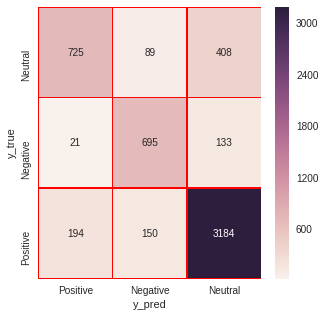

In [0]:
y_pred = random_forest.predict(x_test)
# y_pred = y_pred.argmax(axis=1)
y_true = y_test

from sklearn.metrics import confusion_matrix
import seaborn as sns

names=["Positive","Negative","Neutral"]
cm=confusion_matrix(y_true,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.77      0.59      0.67      1222
         1.0       0.74      0.82      0.78       849
         2.0       0.85      0.90      0.88      3528

   micro avg       0.82      0.82      0.82      5599
   macro avg       0.79      0.77      0.78      5599
weighted avg       0.82      0.82      0.82      5599

